# Data Analysis
This is the main notebook performing all feature engineering, model selection, training, evaluation etc.  
The different steps are:
 - Step1 - import dependencies
 - Step2 - load payloads into memory
 - Step3A - Feature engineering custom features
 - Step3B - Feature engineering bag-of-words
 - Step3C - Feature space visualization
 - Step4 - Model selection
 - (Step4B - Load pre-trained classifiers)
 - Step5 - Visualization
 - Step6 - Website integration extract

# Step1
import dependencies

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import string
from IPython.display import display
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import learning_curve
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import NearestNeighbors
# from sklearn.neighbors.nearest_centroid import NearestCentroid
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier


import sklearn.gaussian_process.kernels as kernels

from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

from scipy.stats import expon

# Step2
load the payloads into memory

In [2]:
cd D:\1MYFILES\ML_NGFW\FIREWALLS\-Machine-Learning-Web-Application-Firewall-and-Dataset-master

D:\1MYFILES\ML_NGFW\FIREWALLS\-Machine-Learning-Web-Application-Firewall-and-Dataset-master


In [3]:
payloads = pd.read_csv("data/payloads.csv",index_col='index')
display(payloads.head(100))

,payload,is_malicious,injection_type
index,,,
0,37662577P,0.0,LEGAL
1,shirting,0.0,LEGAL
2,&kw=%27;alert%28%27XSS%27%29;//,1.0,XSS
3,obeying,0.0,LEGAL
4,dictating,0.0,LEGAL
...,...,...,...
95,diagonal,0.0,LEGAL
96,47513,0.0,LEGAL
97,synapses,0.0,LEGAL


In [4]:
count = payloads['injection_type'].value_counts() 
%matplotlib notebook 
import matplotlib.pyplot as plt
# count.plot.pie(figsize=(10,10))

# Step3A - feature engineering custom features  
We will create our own feature space with features that might be important for this task, this includes:
 - length of payload
 - number of non-printable characters in payload
 - number of punctuation characters in payload
 - the minimum byte value of payload
 - the maximum byte value of payload
 - the mean byte value of payload
 - the standard deviation of payload byte values
 - number of distinct bytes in payload
 - number of SQL keywords in payload
 - number of javascript keywords in payload

In [5]:
def plot_feature_distribution(features):
    print('Properties of feature: ' + features.name)
    print(features.describe())
    f, ax = plt.subplots(1, figsize=(10, 6))
    ax.hist(features, bins=features.max()-features.min()+1) # , normed=1
    ax.set_xlabel('value')
    ax.set_ylabel('fraction')
    
    plt.show()

In [6]:
def create_feature_length(payloads):
    '''
        Feature describing the lengh of the input
    '''
    
    
    payloads['length'] = [len(str(row)) for row in payloads['payload']]
    return payloads


payloads = create_feature_length(payloads)
display(payloads.head())

print(payloads.describe())
# plot_feature_distribution(payloads['length'])


,payload,is_malicious,injection_type,length
index,,,,
0,37662577P,0.0,LEGAL,9
1,shirting,0.0,LEGAL,8
2,&kw=%27;alert%28%27XSS%27%29;//,1.0,XSS,31
3,obeying,0.0,LEGAL,7
4,dictating,0.0,LEGAL,9


        is_malicious         length
count  101840.000000  101840.000000
mean        0.089601      19.370984
std         0.285611     878.975667
min         0.000000       1.000000
25%         0.000000       6.000000
50%         0.000000       9.000000
75%         0.000000      14.000000
max         1.000000  280330.000000


In [7]:
def create_feature_non_printable_characters(payloads):  
    '''
    Feature
    Number of non printable characthers within payload
    '''
    
    payloads['non-printable'] = [ len([1 for letter in str(row) if letter not in str('printable')]) for row in payloads['payload']]
    return payloads
    

create_feature_non_printable_characters(payloads)
display(payloads.head())

print(payloads.describe())

# plot_feature_distribution(payloads['non-printable'])


,payload,is_malicious,injection_type,length,non-printable
index,,,,,
0,37662577P,0.0,LEGAL,9,9
1,shirting,0.0,LEGAL,8,3
2,&kw=%27;alert%28%27XSS%27%29;//,1.0,XSS,31,26
3,obeying,0.0,LEGAL,7,3
4,dictating,0.0,LEGAL,9,3


        is_malicious         length  non-printable
count  101840.000000  101840.000000  101840.000000
mean        0.089601      19.370984      13.453780
std         0.285611     878.975667     878.276776
min         0.000000       1.000000       0.000000
25%         0.000000       6.000000       3.000000
50%         0.000000       9.000000       4.000000
75%         0.000000      14.000000       9.000000
max         1.000000  280330.000000  280173.000000


In [8]:
def create_feature_punctuation_characters(payloads):
    '''
    Feature
    Number of punctuation characthers within payload
    '''
    
    payloads['punctuation'] = [ len([1 for letter in str(row) if letter in str('punctuation')]) for row in payloads['payload']]
    return payloads
    

create_feature_punctuation_characters(payloads)
display(payloads.head())
    
# plot_feature_distribution(payloads['punctuation'])

,payload,is_malicious,injection_type,length,non-printable,punctuation
index,,,,,,
0,37662577P,0.0,LEGAL,9,9,0
1,shirting,0.0,LEGAL,8,3,4
2,&kw=%27;alert%28%27XSS%27%29;//,1.0,XSS,31,26,2
3,obeying,0.0,LEGAL,7,3,3
4,dictating,0.0,LEGAL,9,3,7


In [9]:
def create_feature_min_byte_value(payloads):
    '''
    Feature
    Minimum byte value in payload
    '''
    
    payloads['min-byte'] = [ min(bytearray(str(row), 'utf8')) for row in payloads['payload']]
    return payloads

create_feature_min_byte_value(payloads)
display(payloads.head())

# plot_feature_distribution(payloads['min-byte'])

,payload,is_malicious,injection_type,length,non-printable,punctuation,min-byte
index,,,,,,,
0,37662577P,0.0,LEGAL,9,9,0,50
1,shirting,0.0,LEGAL,8,3,4,103
2,&kw=%27;alert%28%27XSS%27%29;//,1.0,XSS,31,26,2,37
3,obeying,0.0,LEGAL,7,3,3,98
4,dictating,0.0,LEGAL,9,3,7,97


In [10]:
def create_feature_max_byte_value(payloads):
    '''
    Feature
    Maximum byte value in payload
    '''
    
    payloads['max-byte'] = [ max(bytearray(str(row), 'utf8')) for row in payloads['payload']]
    return payloads

create_feature_max_byte_value(payloads)
display(payloads.head())

# plot_feature_distribution(payloads['max-byte'])

,payload,is_malicious,injection_type,length,non-printable,punctuation,min-byte,max-byte
index,,,,,,,,
0,37662577P,0.0,LEGAL,9,9,0,50,80
1,shirting,0.0,LEGAL,8,3,4,103,116
2,&kw=%27;alert%28%27XSS%27%29;//,1.0,XSS,31,26,2,37,119
3,obeying,0.0,LEGAL,7,3,3,98,121
4,dictating,0.0,LEGAL,9,3,7,97,116


In [11]:
def create_feature_mean_byte_value(payloads):
    '''
    Feature
    Maximum byte value in payload
    '''
    
    payloads['mean-byte'] = [ np.mean(bytearray(str(row), 'utf8')) for row in payloads['payload']]
    return payloads

create_feature_mean_byte_value(payloads)
display(payloads.head())

# plot_feature_distribution(payloads['mean-byte'].astype(int))

,payload,is_malicious,injection_type,length,non-printable,punctuation,min-byte,max-byte,mean-byte
index,,,,,,,,,
0,37662577P,0.0,LEGAL,9,9,0,50,80,56.333333
1,shirting,0.0,LEGAL,8,3,4,103,116,109.000000
2,&kw=%27;alert%28%27XSS%27%29;//,1.0,XSS,31,26,2,37,119,65.806452
3,obeying,0.0,LEGAL,7,3,3,98,121,107.000000
4,dictating,0.0,LEGAL,9,3,7,97,116,105.666667


In [12]:
def create_feature_std_byte_value(payloads):
    '''
    Feature
    Standard deviation byte value in payload
    '''
    
    payloads['std-byte'] = [ np.std(bytearray(str(row), 'utf8')) for row in payloads['payload']]
    return payloads

create_feature_std_byte_value(payloads)
display(payloads.head())

# plot_feature_distribution(payloads['std-byte'].astype(int))

,payload,is_malicious,injection_type,length,non-printable,punctuation,min-byte,max-byte,mean-byte,std-byte
index,,,,,,,,,,
0,37662577P,0.0,LEGAL,9,9,0,50,80,56.333333,8.537499
1,shirting,0.0,LEGAL,8,3,4,103,116,109.000000,5.049752
2,&kw=%27;alert%28%27XSS%27%29;//,1.0,XSS,31,26,2,37,119,65.806452,26.617263
3,obeying,0.0,LEGAL,7,3,3,98,121,107.000000,7.151423
4,dictating,0.0,LEGAL,9,3,7,97,116,105.666667,6.599663


In [13]:
def create_feature_distinct_bytes(payloads):
    '''
    Feature
    Number of distinct bytes in payload
    '''
    
    payloads['distinct-bytes'] = [ len(list(set(bytearray(str(row), 'utf8')))) for row in payloads['payload']]
    return payloads

create_feature_distinct_bytes(payloads)
display(payloads.head())

# plot_feature_distribution(payloads['distinct-bytes'])

,payload,is_malicious,injection_type,length,non-printable,punctuation,min-byte,max-byte,mean-byte,std-byte,distinct-bytes
index,,,,,,,,,,,
0,37662577P,0.0,LEGAL,9,9,0,50,80,56.333333,8.537499,6
1,shirting,0.0,LEGAL,8,3,4,103,116,109.000000,5.049752,7
2,&kw=%27;alert%28%27XSS%27%29;//,1.0,XSS,31,26,2,37,119,65.806452,26.617263,18
3,obeying,0.0,LEGAL,7,3,3,98,121,107.000000,7.151423,7
4,dictating,0.0,LEGAL,9,3,7,97,116,105.666667,6.599663,7


In [14]:
sql_keywords = pd.read_csv('data/SQLKeywords.txt', index_col=False)

def create_feature_sql_keywords(payloads):
    
    '''
    Feature
    Number of SQL keywords within payload
    '''
    payloads['sql-keywords'] = [ len([1 for keyword in sql_keywords['Keyword'] if str(keyword).lower() in str(row).lower()]) for row in payloads['payload']]
    return payloads

create_feature_sql_keywords(payloads)
display(type(sql_keywords))
display(payloads.head())
# plot_feature_distribution(payloads['sql-keywords'])
    

pandas.core.frame.DataFrame

,payload,is_malicious,injection_type,length,non-printable,punctuation,min-byte,max-byte,mean-byte,std-byte,distinct-bytes,sql-keywords
index,,,,,,,,,,,,
0,37662577P,0.0,LEGAL,9,9,0,50,80,56.333333,8.537499,6,0
1,shirting,0.0,LEGAL,8,3,4,103,116,109.000000,5.049752,7,0
2,&kw=%27;alert%28%27XSS%27%29;//,1.0,XSS,31,26,2,37,119,65.806452,26.617263,18,0
3,obeying,0.0,LEGAL,7,3,3,98,121,107.000000,7.151423,7,0
4,dictating,0.0,LEGAL,9,3,7,97,116,105.666667,6.599663,7,0


In [15]:
js_keywords = pd.read_csv('data/JavascriptKeywords.txt', index_col=False)

def create_feature_javascript_keywords(payloads):
    '''
    Feature
    Number of Javascript keywords within payload
    '''
    
    payloads['js-keywords'] = [len([1 for keyword in js_keywords['Keyword'] if str(keyword).lower() in str(row).lower()]) for row in payloads['payload']]
    return payloads
    

create_feature_javascript_keywords(payloads)
display(payloads.head())    
# plot_feature_distribution(payloads['js-keywords'])
payloads.to_csv('final_payload.csv')
    

,payload,is_malicious,injection_type,length,non-printable,punctuation,min-byte,max-byte,mean-byte,std-byte,distinct-bytes,sql-keywords,js-keywords
index,,,,,,,,,,,,,
0,37662577P,0.0,LEGAL,9,9,0,50,80,56.333333,8.537499,6,0,0
1,shirting,0.0,LEGAL,8,3,4,103,116,109.000000,5.049752,7,0,1
2,&kw=%27;alert%28%27XSS%27%29;//,1.0,XSS,31,26,2,37,119,65.806452,26.617263,18,0,1
3,obeying,0.0,LEGAL,7,3,3,98,121,107.000000,7.151423,7,0,1
4,dictating,0.0,LEGAL,9,3,7,97,116,105.666667,6.599663,7,0,1


In [16]:
payloads

,payload,is_malicious,injection_type,length,non-printable,punctuation,min-byte,max-byte,mean-byte,std-byte,distinct-bytes,sql-keywords,js-keywords
index,,,,,,,,,,,,,
0,37662577P,0.0,LEGAL,9,9,0,50,80,56.333333,8.537499,6,0,0
1,shirting,0.0,LEGAL,8,3,4,103,116,109.000000,5.049752,7,0,1
2,&kw=%27;alert%28%27XSS%27%29;//,1.0,XSS,31,26,2,37,119,65.806452,26.617263,18,0,1
3,obeying,0.0,LEGAL,7,3,3,98,121,107.000000,7.151423,7,0,1
4,dictating,0.0,LEGAL,9,3,7,97,116,105.666667,6.599663,7,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
110355,needlessness,0.0,LEGAL,12,5,2,100,115,107.666667,6.209312,5,1,0
110356,Mary-Jo,0.0,LEGAL,7,5,2,45,121,91.285714,25.257046,7,0,0
110357,marshaled,0.0,LEGAL,9,4,2,97,115,105.000000,6.463573,8,0,0


define a function that makes a feature vector from the payload using the custom features

In [17]:
def create_features(payloads):
    features = create_feature_length(payloads)
    features = create_feature_non_printable_characters(features)
    features = create_feature_punctuation_characters(features)
    features = create_feature_max_byte_value(features)
    features = create_feature_min_byte_value(features)
    features = create_feature_mean_byte_value(features)
    features = create_feature_std_byte_value(features)
    features = create_feature_distinct_bytes(features)
    features = create_feature_sql_keywords(features)
    features = create_feature_javascript_keywords(features)
    del features['payload']

    return features

### Scoring custom features
Score the custom features using the SelectKBest function, then visualize the scores in a graph  
to see which features are less significant

[3299723.32025039 3327136.76438578  245016.49373881   10980.99315416
  193459.52018629   15539.63260562  186189.95436531  268592.66428084
   31279.28883915   45707.16380364]
[3299723.32 3327136.76  245016.49   10980.99  193459.52   15539.63
  186189.95  268592.66   31279.29   45707.16]


['max-byte',
 'mean-byte',
 'sql-keywords',
 'js-keywords',
 'std-byte',
 'min-byte',
 'punctuation',
 'distinct-bytes',
 'length',
 'non-printable']

['js-keywords 10980.993154162034',
 'min-byte 15539.632605624796',
 'length 31279.288839146047',
 'non-printable 45707.16380364161',
 'punctuation 186189.9543653096',
 'std-byte 193459.52018629215',
 'sql-keywords 245016.49373880975',
 'distinct-bytes 268592.66428084375',
 'max-byte 3299723.3202503854',
 'mean-byte 3327136.7643857826']

<IPython.core.display.Javascript object>


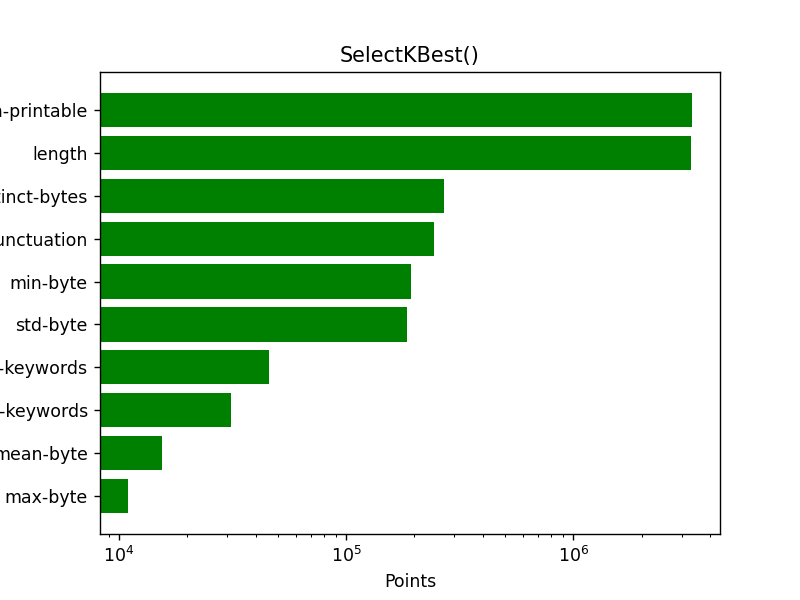

Text(0.5, 1.0, 'SelectKBest()')

In [122]:
Y = payloads['is_malicious']
X = create_features(pd.DataFrame(payloads['payload'].copy()))

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

test = SelectKBest(score_func=chi2, k='all')
fit = test.fit(X, Y)
# summarize scores
print(fit.scores_)
features = fit.transform(X)
# summarize selected features
# summarize scores
np.set_printoptions(precision=2)
print(fit.scores_)

# Get the indices sorted by most important to least important
indices = np.argsort(fit.scores_)

# To get your top 10 feature names
featuress = []
for i in range(10):
    featuress.append(X.columns[indices[i]])

display(featuress)
display([featuress[i] + ' ' + str(fit.scores_[i]) for i in indices[range(10)]])


plt.rcdefaults()
fig, ax = plt.subplots()

y_pos = np.arange(len(featuress))
performance = 3 + 10 * np.random.rand(len(featuress))
error = np.random.rand(len(featuress))

ax.barh(y_pos, fit.scores_[indices[range(10)]],  align='center',
        color='green', ecolor='black')
ax.set_yticks(y_pos)
ax.set_yticklabels(featuress)
ax.set_xscale('log')

#ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Points')
ax.set_title('SelectKBest()')

# plt.show()







# Step3B - Feature engineering using bag of words techniques.
Additional to our custom feature space, we will create 6 more feature spaces using bag-of-words techniques  
The following vectorizers below is another way of creating features for text input.  
We will test the performance of these techniques independently from our custom features in Step 3A.  
We will create vectorizers of these combinations:
- 1-grams CountVectorizer
- 2-grams CountVectorizer
- 3-grams CountVectorizer
- There are some significant data values in which you need not them as a training data set as it reduces the accuracy. in order to remove all those significant values we use term frequency and Inverse Data frequency 
- 1-grams TfidfVectorizer
- 2-grams TfidfVectorizer
- 3-grams TfidfVectorizer

The type of N-gram function determines how the actual "words" should be created from the payload string  
Each vectorizer is used later in Step4 in Pipeline objects before training  
See report for further explanation

### 1-Grams features
create a Countvectorizer and TF-IDFvectorizer that uses 1-grams.  
1-grams equals one feature for each letter/symbol recorded

In [18]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

def get1Grams(payload_obj):
    '''Divides a string into 1-grams
    
    Example: input - payload: "<script>"
             output- ["<","s","c","r","i","p","t",">"]
    '''
    payload = str(payload_obj)
    ngrams = []
    for i in range(0,len(payload)-1):
        ngrams.append(payload[i:i+1])
    return ngrams

tfidf_vectorizer_1grams = TfidfVectorizer(tokenizer=get1Grams)
count_vectorizer_1grams = CountVectorizer(min_df=1, tokenizer=get1Grams)

### 2-Grams features
create a Countvectorizer and TF-IDFvectorizer that uses 2-grams.  

In [19]:
def get2Grams(payload_obj):
    '''Divides a string into 2-grams
    
    Example: input - payload: "<script>"
             output- ["<s","sc","cr","ri","ip","pt","t>"]
    '''
    payload = str(payload_obj)
    ngrams = []
    for i in range(0,len(payload)-2):
        ngrams.append(payload[i:i+2])
    return ngrams

tfidf_vectorizer_2grams = TfidfVectorizer(tokenizer=get2Grams)
count_vectorizer_2grams = CountVectorizer(min_df=1, tokenizer=get2Grams)

### 3-Grams features
Create a Countvectorizer and TF-IDFvectorizer that uses 3-grams

In [20]:
def get3Grams(payload_obj):
    '''Divides a string into 3-grams
    
    Example: input - payload: "<script>"
             output- ["<sc","scr","cri","rip","ipt","pt>"]
    '''
    payload = str(payload_obj)
    ngrams = []
    for i in range(0,len(payload)-3):
        ngrams.append(payload[i:i+3])
    return ngrams

tfidf_vectorizer_3grams = TfidfVectorizer(tokenizer=get3Grams)
count_vectorizer_3grams = CountVectorizer(min_df=1, tokenizer=get3Grams)

## Step3C - Feature space visualization
After creating our different feature spaces to later train each classifier on,  
we first examine them visually by projecting the feature spaces into two dimensions using Principle Component Analysis  
Graphs are shown below displaying the data in 3 out of 7 of our feature spaces

In [22]:
def visualize_feature_space_by_projection(X,Y,title='PCA'):
    '''Plot a two-dimensional projection of the dataset in the specified feature space
    
    input: X - data
           Y - labels
           title - title of plot
    '''
    pca = TruncatedSVD(n_components=2)
    X_r = pca.fit(X).transform(X)

    # Percentage of variance explained for each components
    print('explained variance ratio (first two components): %s'
          % str(pca.explained_variance_ratio_))

    plt.figure()
    colors = ['blue', 'darkorange']
    lw = 2

    #Plot malicious and non-malicious separately with different colors
    for color, i, y in zip(colors, [0, 1], Y):
        plt.scatter(X_r[Y == i, 0], X_r[Y == i, 1], color=color, alpha=.3, lw=lw,
                    label=i)
        
    plt.legend(loc='best', shadow=False, scatterpoints=1)
    plt.title(title)
    plt.show()

### 1-Grams CountVectorizer feature space visualization

In [23]:
from sklearn.decomposition import TruncatedSVD

X = count_vectorizer_1grams.fit_transform(payloads['payload'].apply(lambda x: np.str_(x)))
# (payloads['payload'].values.astype('U'))
# (payloads['payload'].apply(lambda x: np.str_(x)))
Y = payloads['is_malicious']
# visualize_feature_space_by_projection(X,Y,title='PCA visualization of 1-grams CountVectorizer feature space')

### 3-Grams TFIDFVectorizer feature space visualization

In [24]:
X = tfidf_vectorizer_3grams.fit_transform(payloads['payload'].apply(lambda x: np.str_(x)))
Y = payloads['is_malicious']
# visualize_feature_space_by_projection(X,Y,title='PCA visualization of 3-grams TFIDFVectorizer feature space')

### Custom feature space visualization

In [25]:
X = create_features(pd.DataFrame(payloads['payload'].copy()))
Y = payloads['is_malicious']
# visualize_feature_space_by_projection(X,Y,title='PCA visualization of custom feature space')

#  Step4 - Model selection and evaluation

First, we will automate hyperparameter tuning and out of sample testing using train_model below

In [26]:
def train_model(clf, param_grid, X, Y):
    '''Trains and evaluates the model clf from input
    
    The function selects the best model of clf by optimizing for the validation data,
    then evaluates its performance using the out of sample test data.
    
    input - clf: the model to train
            param_grid: a dict of hyperparameters to use for optimization
            X: features
            Y: labels
    
    output - the best estimator (trained model)
             the confusion matrix from classifying the test data
    '''
    
    #First, partition into train and test data
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

    max_iter = 5
    #If number of possible iterations are less than prefered number of iterations, 
    #set it to the number of possible iterations
    #number of possible iterations are not less than prefered number of iterations if any argument is expon()
    #because expon() is continous (writing 100 instead, could be any large number)
    max_iter = min(max_iter,np.prod([
        100 if type(xs) == type(expon()) 
        else len(xs) 
        for xs in param_grid.values()
    ]))
    
    #perform a grid search for the best parameters on the training data.
    #Cross validation is made to select the parameters, so the training data is actually split into
    #a new train data set and a validation data set, K number of times
    cv = ShuffleSplit(len(X_train), test_size=0.2, random_state=0) #DEBUG: n_iter=10
    #cv = KFold(n=len(X), n_folds=10)
    random_grid_search = RandomizedSearchCV(
        clf, 
        param_distributions=param_grid,
        cv=cv, 
        scoring='f1', 
#         max_iter=max_iter, #DEBUG 1 
        random_state=5,
        refit=True,
        verbose=10
    )
    
    '''Randomized search used instead. We have limited computing power
    grid_search = GridSearchCV(
        clf,
        param_grid=param_grid,
        cv=cv,
        scoring='f1', #accuracy/f1/f1_weighted all give same result?
        verbose=10,
        n_jobs=-1
    )
    grid_search.fit(X_train, Y_train)
    '''
    random_grid_search.fit(X_train, Y_train)
    
    #Evaluate the best model on the test data
    Y_test_predicted = random_grid_search.best_estimator_.predict(X_test)
    Y_test_predicted_prob = random_grid_search.best_estimator_.predict_proba(X_test)[:, 1]

    confusion = confusion_matrix(Y_test, Y_test_predicted)
    TP = confusion[1, 1]
    TN = confusion[0, 0]
    FP = confusion[0, 1]
    FN = confusion[1, 0]

    #Calculate recall (sensitivity) from confusion matrix
    sensitivity = TP / float(TP + FN)
    
    #Calculate specificity from confusion matrix
    specificity = TN / float(TN + FP)

    #Calculate accuracy
    accuracy = (confusion[0][0] + confusion[1][1]) / (confusion.sum().sum())
    
    #Calculate axes of ROC curve
    fpr, tpr, thresholds = roc_curve(Y_test, Y_test_predicted_prob)
    
    #Area under the ROC curve
    auc = roc_auc_score(Y_test, Y_test_predicted_prob)

    return {
        'conf_matrix':confusion, 
        'accuracy':accuracy, 
        'sensitivity':sensitivity,
        'specificity':specificity,
        'auc':auc,
        'params':random_grid_search.best_params_,
        'model':random_grid_search.best_estimator_,
        'roc':{'fpr':fpr,'tpr':tpr,'thresholds':thresholds}
    }


Then, we will use the train_model function to train, optimize and retrieve out of sample testing results from a range of classifiers.  
Classifiers tested using our custom feature space:
 - AdaBoost
 - SGD classifier 
 - MultiLayerPerceptron classifier
 - Logistic Regression
 - Support Vector Machine
 - Random forest
 - Decision Tree
 - Multinomial Naive Bayes

Classifiers tested using bag-of-words feature spaces:
 - MultiLayerPerceptron classifier
 - Logistic Regression
 - Support Vector Machine
 - Random forest
 - Multinomial Naive Bayes
 
 Some classifiers were unable to train using a bag-of-words feature space because they couldn't handle sparse graphs
 
 All their best parameters with their performance is stored in a dataframe called classifier_results

Make dictionary of models with parameters to optimize using bag-of-words feature spaces

In [126]:
def create_classifier_inputs_using_vectorizers(vectorizer, subscript):
    '''make pipelines of the specified vectorizer with the classifiers to train
    
    input - vectorizer: the vectorizer to add to the pipelines
            subscript:  subscript name for the dictionary key
            
    output - A dict of inputs to use for train_model(); a pipeline and a dict of params to optimize
    '''
    
    classifier_inputs = {}
    
    classifier_inputs[subscript + ' RandomForest'] = {
        'pipeline':Pipeline([('vect', vectorizer),('clf',RandomForestClassifier(
            max_depth=None,min_samples_split=2, random_state=0))]),
        'dict_params': {
#             'vect__min_df':[1],#,2,5,10,20,40
#             'clf__n_estimators':[10]#,20,40,60
        }
    }
    '''
    classifier_inputs[subscript + ' MLPClassifier'] = {
        'pipeline':Pipeline([('vect', vectorizer),('clf',MLPClassifier(
            activation='relu',
            solver='adam',
            early_stopping=False,
            verbose=True
            
        ))]),
        'dict_params': {
            'vect__min_df':[1,2,5,10,20,40],
            'clf__hidden_layer_sizes':[(500,250,125,62)],
            'clf__alpha':[0.0005,0.001,0.01,0.1,1],
            'clf__learning_rate':['constant','invscaling'],
            'clf__learning_rate_init':[0.001,0.01,0.1,1],
            'clf__momentum':[0,0.9],
        }
    }

    classifier_inputs[subscript + ' MultinomialNB'] = {
        'pipeline':Pipeline([('vect', vectorizer),('clf',MultinomialNB())]),
        'dict_params': {
            'vect__min_df':[1,2,5,10,20,40]
        }
    }

    classifier_inputs[subscript + ' Logistic'] = {
        'pipeline':Pipeline([('vect', vectorizer), ('clf',LogisticRegression())]),
        'dict_params': {
            'vect__min_df':[1,2,5,10,20,40],
            'clf__C':[0.001, 0.01, 0.1, 1, 10, 100, 1000]
        }
    }
    classifier_inputs[subscript + ' SVM'] = { 
        'pipeline':Pipeline([('vect', vectorizer), ('clf',SVC(probability=True))]),
        'dict_params': {
            'vect__min_df':[1,2,5,10,20,40],
            'clf__C':[0.001, 0.01, 0.1, 1, 10, 100, 1000],
            'clf__gamma':[0.001, 0.0001,'auto'],
            'clf__kernel':['rbf']
        }
    }
    '''
    
    return classifier_inputs


Make dictionary of models with parameters to optimize using custom feature spaces

In [127]:
def create_classifier_inputs(subscript):
    
    classifier_inputs = {}
    
    classifier_inputs[subscript + ' RandomForest'] = {
        'pipeline':RandomForestClassifier(
            max_depth=None,min_samples_split=2, random_state=0),
        'dict_params': {
            'n_estimators':[10]#,20,40,60
        }
    }
    '''
    classifier_inputs[subscript + ' GPC'] = {
        'pipeline':GaussianProcessClassifier(),
        'dict_params': {
            'kernel':[
                1.0*kernels.RBF(1.0),
                1.0*kernels.Matern(),
                1.0*kernels.RationalQuadratic(),
                1.0*kernels.DotProduct()
            ]
        }
    }
    classifier_inputs[subscript + ' AdaBoostClassifier'] = {
        'pipeline':AdaBoostClassifier(n_estimators=100),
        'dict_params': {
            'n_estimators':[10,20,50, 100], 
            'learning_rate':[0.1, 0.5, 1.0, 2.0]
        }
    }
    classifier_inputs[subscript + ' SGD'] = {
        'pipeline':SGDClassifier(loss="log", penalty="l2"),
        'dict_params': {
            'learning_rate': ['optimal']
        }
    }

    classifier_inputs[subscript + ' DecisionTree'] = {
        'pipeline':  DecisionTreeClassifier(max_depth=5),
        'dict_params': {
            'min_samples_split': [2]
        }
    }

    classifier_inputs[subscript + ' MLPClassifier'] = {
        'pipeline':MLPClassifier(
            activation='relu',
            solver='adam',
            early_stopping=False,
            verbose=True
            
        ),
        'dict_params': {
            'hidden_layer_sizes':[(300, 200, 150, 150), (30, 30, 30), (150, 30, 30, 150), 
                                  (400, 250, 100, 100) , (150, 200, 300)],
            'alpha':[0.0005,0.001,0.01,0.1,1],
            'learning_rate':['constant','invscaling'],
            'learning_rate_init':[0.0005,0.001,0.01,0.1,1],
            'momentum':[0,0.9],
        }
    }

    classifier_inputs[subscript + ' Logistic'] = {
        'pipeline':LogisticRegression(),
        'dict_params': {
            'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
        }
    }
    classifier_inputs[subscript + ' MultinomialNB'] = {
        'pipeline':MultinomialNB(),
        'dict_params': {
            'alpha': [1.0]
        }
    }
    
    classifier_inputs[subscript + ' SVM'] = {
        'pipeline':SVC(probability=True),
        'dict_params': {
            'C':[0.001, 0.01, 0.1, 1, 10, 100, 1000],
            'gamma':[0.001, 0.0001,'auto'],
            'kernel':['rbf']
        }
    }
    '''
    return classifier_inputs
    

Create a new result table

In [128]:
classifier_results = pd.DataFrame(columns=['accuracy','sensitivity','specificity','auc','conf_matrix','params','model','roc'])#,index=classifier_inputs.keys())
display(classifier_results) 

,accuracy,sensitivity,specificity,auc,conf_matrix,params,model,roc


# MY CUSTOM TRANSFORMATION USING COUNT AND TF-IDF 

In [131]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer # Vectorizes the tokens into a matrix 

cv = CountVectorizer() 
count_vectorizer_1grams = CountVectorizer(min_df=1, tokenizer=get1Grams)
count_vectorizer_1grams = CountVectorizer(min_df=1, tokenizer=get2Grams)
count_vectorizer_1grams = CountVectorizer(min_df=1, tokenizer=get3Grams)

tfidf_vectorizer_1grams = TfidfVectorizer(tokenizer=get1Grams)
tfidf_vectorizer_1grams = TfidfVectorizer(tokenizer=get2Grams)
tfidf_vectorizer_1grams = TfidfVectorizer(tokenizer=get3Grams)

- PIPELINE A MODEL WITH A VECTORIZER / TRANSFORMER 
- GET THE TOKENIZED DATA 
- FIT THE TOKENIZED DATA USING A VECTORIZER 
- TRAIN_TEST_SPLIT USING FIT_TOKENIZED DATA & LABELLED DATA WITH TRAIN:TEST DATA RATIO 
- FIT THE MODEL WITH TRAINED DATA i.e. TRAINX, TRAINY 
- TEST THE MODEL 
- SERIALIZE THE MODEL --> DUMPING THE MODEL INTO PICKLE FILE 
- WEB INTEGRATION 

In [132]:
# PIPELINING WITH EVERY INDIVIDUAL MODEL WITH DIFFERENT N GRAMS 
from sklearn.pipeline import make_pipeline 
lr_count_1 = make_pipeline(count_vectorizer_1grams, LogisticRegression()) 

In [133]:
# AVOIDED THE ERROR OF UNABLE TO ALLOCATE 318 KIB BY CALLING ONLY count_vectorizer_1grams FUNCTION
X = count_vectorizer_1grams.fit_transform(payloads['payload'].apply(lambda x: np.str_(x)))
Y = payloads['is_malicious']
X 

<101840x54265 sparse matrix of type '<class 'numpy.int64'>'
	with 1219359 stored elements in Compressed Sparse Row format>

In [134]:
import xgboost as xgb
xgb_classifier = xgb.XGBClassifier()

from sklearn.ensemble import AdaBoostClassifier
ada_classifier = AdaBoostClassifier()

from sklearn.linear_model import SGDClassifier
sgd_classifier = SGDClassifier() 

from sklearn.linear_model import LogisticRegression
lr_classifier = LogisticRegression(max_iter = 110359) 

from sklearn.ensemble import RandomForestClassifier
rf_classifier = RandomForestClassifier() 

from sklearn.svm import SVC
svm_classifier = SVC() 

from sklearn.tree import DecisionTreeClassifier
dt_classifier = DecisionTreeClassifier() 

from sklearn.naive_bayes import MultinomialNB
mnb_classifier = MultinomialNB() 

In [ ]:
trainX, testX, trainY, testY = train_test_split(X, Y)

In [ ]:
sgd_classifier.fit(trainX,trainY)

In [90]:
ada_classifier.fit(trainX,trainY)

AdaBoostClassifier()

In [91]:
sgd_classifier.fit(trainX,trainY)

SGDClassifier()

In [92]:
lr_classifier.fit(trainX,trainY)

LogisticRegression(max_iter=110359)

In [95]:
svm_classifier.fit(trainX,trainY)

SVC()

In [96]:
dt_classifier.fit(trainX,trainY)

DecisionTreeClassifier()

In [97]:
mnb_classifier.fit(trainX,trainY)

MultinomialNB()

In [100]:
cd gram_models

D:\1MYFILES\ML_NGFW\FIREWALLS\-Machine-Learning-Web-Application-Firewall-and-Dataset-master\gram_models


In [102]:
pickle.dump(xgb_classifier,open("xgb_classifier_cv_1.pkl","wb"))
pickle.dump(ada_classifier,open("ada_classifier_cv_1.pkl","wb"))
pickle.dump(sgd_classifier,open("sgd_classifier_cv_1.pkl","wb"))
pickle.dump(lr_classifier,open("lr_classifier_cv_1.pkl","wb"))
pickle.dump(rf_classifier,open("rf_classifier_cv_1.pkl","wb"))
pickle.dump(svm_classifier,open("svm_classifier_cv_1.pkl","wb"))
pickle.dump(dt_classifier,open("dt_classifier_cv_1.pkl","wb"))
pickle.dump(mnb_classifier,open("mnb_classifier_cv_1.pkl","wb"))

In [103]:
X = count_vectorizer_2grams.fit_transform(payloads['payload'].apply(lambda x: np.str_(x)))
Y = payloads['is_malicious']

In [104]:
trainX, testX, trainY, testY = train_test_split(X, Y, test_size = 0.2)

In [105]:
rf_classifier.fit(trainX,trainY)

RandomForestClassifier()

In [106]:
xgb_classifier.fit(trainX,trainY)


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [107]:
ada_classifier.fit(trainX,trainY)


AdaBoostClassifier()

In [108]:
sgd_classifier.fit(trainX,trainY)


SGDClassifier()

In [109]:
lr_classifier.fit(trainX,trainY)


LogisticRegression(max_iter=110359)

In [110]:
svm_classifier.fit(trainX,trainY)


SVC()

In [111]:
dt_classifier.fit(trainX,trainY)

DecisionTreeClassifier()

In [112]:
mnb_classifier.fit(trainX,trainY)

MultinomialNB()

In [115]:
pickle.dump(xgb_classifier,open("xgb_classifier_cv_2.pkl","wb"))
pickle.dump(ada_classifier,open("ada_classifier_cv_2.pkl","wb"))
pickle.dump(sgd_classifier,open("sgd_classifier_cv_2.pkl","wb"))
pickle.dump(lr_classifier,open("lr_classifier_cv_2.pkl","wb"))
pickle.dump(rf_classifier,open("rf_classifier_cv_2.pkl","wb"))
pickle.dump(svm_classifier,open("svm_classifier_cv_2.pkl","wb"))
pickle.dump(dt_classifier,open("dt_classifier_cv_2.pkl","wb"))
pickle.dump(mnb_classifier,open("mnb_classifier_cv_2.pkl","wb"))

In [117]:
X = count_vectorizer_3grams.fit_transform(payloads['payload'].apply(lambda x: np.str_(x)))
Y = payloads['is_malicious']

In [118]:
trainX, testX, trainY, testY = train_test_split(X, Y, test_size = 0.2)

In [119]:
rf_classifier.fit(trainX,trainY)

RandomForestClassifier()

In [120]:
xgb_classifier.fit(trainX,trainY)


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [121]:
ada_classifier.fit(trainX,trainY)


AdaBoostClassifier()

In [122]:
sgd_classifier.fit(trainX,trainY)


SGDClassifier()

In [123]:
lr_classifier.fit(trainX,trainY)


LogisticRegression(max_iter=110359)

In [124]:
svm_classifier.fit(trainX,trainY)


SVC()

In [125]:
dt_classifier.fit(trainX,trainY)


DecisionTreeClassifier()

In [126]:
mnb_classifier.fit(trainX,trainY)

MultinomialNB()

In [127]:
pickle.dump(xgb_classifier,open("xgb_classifier_cv_3.pkl","wb"))
pickle.dump(ada_classifier,open("ada_classifier_cv_3.pkl","wb"))
pickle.dump(sgd_classifier,open("sgd_classifier_cv_3.pkl","wb"))
pickle.dump(lr_classifier,open("lr_classifier_cv_3.pkl","wb"))
pickle.dump(rf_classifier,open("rf_classifier_cv_3.pkl","wb"))
pickle.dump(svm_classifier,open("svm_classifier_cv_3.pkl","wb"))
pickle.dump(dt_classifier,open("dt_classifier_cv_3.pkl","wb"))
pickle.dump(mnb_classifier,open("mnb_classifier_cv_3.pkl","wb"))

# TF-IDF N GRAMS VECTORIZERS

In [128]:
X = tfidf_vectorizer_1grams.fit_transform(payloads['payload'].apply(lambda x: np.str_(x)))
Y = payloads['is_malicious']

In [129]:
trainX, testX, trainY, testY = train_test_split(X, Y, test_size = 0.2)

In [130]:
rf_classifier.fit(trainX,trainY)


RandomForestClassifier()

In [131]:
xgb_classifier.fit(trainX,trainY)


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [132]:
ada_classifier.fit(trainX,trainY)


AdaBoostClassifier()

In [133]:
sgd_classifier.fit(trainX,trainY)


SGDClassifier()

In [134]:
lr_classifier.fit(trainX,trainY)


LogisticRegression(max_iter=110359)

In [135]:
svm_classifier.fit(trainX,trainY)


SVC()

In [136]:
dt_classifier.fit(trainX,trainY)


DecisionTreeClassifier()

In [137]:
mnb_classifier.fit(trainX,trainY)

MultinomialNB()

In [138]:
cd ..

D:\1MYFILES\ML_NGFW\FIREWALLS\-Machine-Learning-Web-Application-Firewall-and-Dataset-master


In [139]:
mkdir tf_gram_models

In [140]:
cd tf_gram_models

D:\1MYFILES\ML_NGFW\FIREWALLS\-Machine-Learning-Web-Application-Firewall-and-Dataset-master\tf_gram_models


In [141]:
pickle.dump(xgb_classifier,open("xgb_classifier_tf_1.pkl","wb"))
pickle.dump(ada_classifier,open("ada_classifier_tf_1.pkl","wb"))
pickle.dump(sgd_classifier,open("sgd_classifier_tf_1.pkl","wb"))
pickle.dump(lr_classifier,open("lr_classifier_tf_1.pkl","wb"))
pickle.dump(rf_classifier,open("rf_classifier_tf_1.pkl","wb"))
pickle.dump(svm_classifier,open("svm_classifier_tf_1.pkl","wb"))
pickle.dump(dt_classifier,open("dt_classifier_tf_1.pkl","wb"))
pickle.dump(mnb_classifier,open("mnb_classifier_tf_1.pkl","wb"))

In [142]:
X = tfidf_vectorizer_2grams.fit_transform(payloads['payload'].apply(lambda x: np.str_(x)))
Y = payloads['is_malicious']

In [143]:
trainX, testX, trainY, testY = train_test_split(X, Y, test_size = 0.2)

In [144]:
rf_classifier.fit(trainX,trainY)


RandomForestClassifier()

In [145]:
xgb_classifier.fit(trainX,trainY)


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [146]:
ada_classifier.fit(trainX,trainY)


AdaBoostClassifier()

In [147]:
sgd_classifier.fit(trainX,trainY)


SGDClassifier()

In [148]:
lr_classifier.fit(trainX,trainY)


LogisticRegression(max_iter=110359)

In [149]:
svm_classifier.fit(trainX,trainY)


SVC()

In [150]:
dt_classifier.fit(trainX,trainY)


DecisionTreeClassifier()

In [151]:
mnb_classifier.fit(trainX,trainY)

MultinomialNB()

In [152]:
pickle.dump(xgb_classifier,open("xgb_classifier_tf_2.pkl","wb"))
pickle.dump(ada_classifier,open("ada_classifier_tf_2.pkl","wb"))
pickle.dump(sgd_classifier,open("sgd_classifier_tf_2.pkl","wb"))
pickle.dump(lr_classifier,open("lr_classifier_tf_2.pkl","wb"))
pickle.dump(rf_classifier,open("rf_classifier_tf_2.pkl","wb"))
pickle.dump(svm_classifier,open("svm_classifier_tf_2.pkl","wb"))
pickle.dump(dt_classifier,open("dt_classifier_tf_2.pkl","wb"))
pickle.dump(mnb_classifier,open("mnb_classifier_tf_2.pkl","wb"))

In [153]:
X = tfidf_vectorizer_3grams.fit_transform(payloads['payload'].apply(lambda x: np.str_(x)))
Y = payloads['is_malicious']

In [154]:
trainX, testX, trainY, testY = train_test_split(X, Y, test_size = 0.2)

In [155]:
rf_classifier.fit(trainX,trainY)
xgb_classifier.fit(trainX,trainY)
ada_classifier.fit(trainX,trainY)
sgd_classifier.fit(trainX,trainY)
lr_classifier.fit(trainX,trainY)
svm_classifier.fit(trainX,trainY)
dt_classifier.fit(trainX,trainY)
mnb_classifier.fit(trainX,trainY)

MultinomialNB()

In [156]:
pickle.dump(xgb_classifier,open("xgb_classifier_tf_3.pkl","wb"))
pickle.dump(ada_classifier,open("ada_classifier_tf_3.pkl","wb"))
pickle.dump(sgd_classifier,open("sgd_classifier_tf_3.pkl","wb"))
pickle.dump(lr_classifier,open("lr_classifier_tf_3.pkl","wb"))
pickle.dump(rf_classifier,open("rf_classifier_tf_3.pkl","wb"))
pickle.dump(svm_classifier,open("svm_classifier_tf_3.pkl","wb"))
pickle.dump(dt_classifier,open("dt_classifier_tf_3.pkl","wb"))
pickle.dump(mnb_classifier,open("mnb_classifier_tf_3.pkl","wb"))

In [4]:
cd gram_models

D:\1MYFILES\ML_NGFW\FIREWALLS\-Machine-Learning-Web-Application-Firewall-and-Dataset-master\gram_models


In [5]:
xgb = pickle.load(open("xgb_classifier_cv_1.pkl", "rb")) 
ada = pickle.load(open("ada_classifier_cv_1.pkl", "rb"))
sgd = pickle.load(open("sgd_classifier_cv_1.pkl", "rb"))
lr = pickle.load(open("lr_classifier_cv_1.pkl", "rb"))
rf = pickle.load(open("rf_classifier_cv_1.pkl", "rb"))
svm = pickle.load(open("svm_classifier_cv_1.pkl", "rb"))
dt = pickle.load(open("dt_classifier_cv_1.pkl", "rb"))
mnb = pickle.load(open("mnb_classifier_cv_1.pkl", "rb"))

In [135]:
X = count_vectorizer_1grams.fit_transform(payloads['payload'].apply(lambda x: np.str_(x)))
Y = payloads['is_malicious']
X

<101840x54265 sparse matrix of type '<class 'numpy.int64'>'
	with 1219359 stored elements in Compressed Sparse Row format>

In [136]:
trainX, testX, trainY, testY = train_test_split(X, Y)

In [137]:
testX

<25460x54265 sparse matrix of type '<class 'numpy.int64'>'
	with 298244 stored elements in Compressed Sparse Row format>

In [139]:
sgd_classifier.fit( trainX , trainY )

SGDClassifier()

In [140]:
sgd_classifier.score( testX , testY ) 

0.994776119402985

In [141]:
sgd_classifier.predict( testX ) 


array([0., 0., 0., ..., 0., 0., 0.])

In [142]:
a = count_vectorizer_1grams.fit_transform(['&kw=%27;alert%28%27XSS%27%29;//'])
sgd_classifier.predict( a ) 


ValueError: X has 26 features, but SGDClassifier is expecting 54265 features as input.

In [72]:
cd ~\anaconda3\lib\site-packages\sklearn

SyntaxError: invalid syntax (279245137.py, line 1)

In [45]:
# ValueError: Feature shape mismatch, expected: 54265, got 172
# ValueError: X has 172 features, but LogisticRegression is expecting 54265 features as input.
# Train size != Test size to know the accuracy and predicting --> trying by not splitting the train & test data and building the model
# ValueError: could not convert string to float: '&kw=%27;alert%28%27XSS%27%29;//' --> when trying to predict 
# ValueError: X has 26 features, but SGDClassifier is expecting 54265 features as input.
# the column size jumped from 172 to 54265 --> {101840x54265}
# because all the data features were included in the csv file 

In [15]:
scores = {} 
scores['xgb'] = xgb.score(testX,testY)
scores['ada'] = ada.score(testX,testY)
scores['sgd'] = sgd.score(testX,testY)
scores['lr'] = lr.score(testX,testY)
scores['rf'] = rf.score(testX,testY)
scores['svm'] = svm.score(testX,testY)
scores['dt'] = dt.score(testX,testY)
scores['mnb'] = mnb.score(testX,testY)

ValueError: Feature shape mismatch, expected: 54265, got 172

# OPTIMAL THRESHOLD CALCULATION

In [22]:
payloads

,payload,is_malicious,injection_type,length,non-printable,punctuation,min-byte,max-byte,mean-byte,std-byte,distinct-bytes,sql-keywords,js-keywords
index,,,,,,,,,,,,,
0,37662577P,0.0,LEGAL,9,9,0,50,80,56.333333,8.537499,6,0,0
1,shirting,0.0,LEGAL,8,3,4,103,116,109.000000,5.049752,7,0,1
2,&kw=%27;alert%28%27XSS%27%29;//,1.0,XSS,31,26,2,37,119,65.806452,26.617263,18,0,1
3,obeying,0.0,LEGAL,7,3,3,98,121,107.000000,7.151423,7,0,1
4,dictating,0.0,LEGAL,9,3,7,97,116,105.666667,6.599663,7,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
110355,needlessness,0.0,LEGAL,12,5,2,100,115,107.666667,6.209312,5,1,0
110356,Mary-Jo,0.0,LEGAL,7,5,2,45,121,91.285714,25.257046,7,0,0
110357,marshaled,0.0,LEGAL,9,4,2,97,115,105.000000,6.463573,8,0,0


In [25]:
payloads['tokens_1'] = payloads.payload.map( lambda t : get1Grams(t))
payloads['tokens_1'].head(10)

index
0                             [3, 7, 6, 6, 2, 5, 7, 7]
1                                [s, h, i, r, t, i, n]
2    [&, k, w, =, %, 2, 7, ;, a, l, e, r, t, %, 2, ...
3                                   [o, b, e, y, i, n]
4                             [d, i, c, t, a, t, i, n]
5                                   [l, a, f, l, e, u]
6                             [c, a, p, t, u, r, e, r]
7                             [8, n, c, a, 5, 8, z, 4]
8                          [a, u, t, o, c, r, a, t, i]
9    [g, r, o, c, e, r, y, +, w, a, r, e, h, o, u, ...
Name: tokens_1, dtype: object

In [26]:
payloads['tokens_1'] = payloads.payload.map(lambda t: get1Grams(t))
payloads['tokens_1'] = payloads['tokens_1'].map(lambda l: ' '.join(str(l)))
payloads.iloc[:,13:] 
# document = [' '.join(str(item)) for item in corpus]

,tokens_1
index,
0,"[ ' 3 ' , ' 7 ' , ' 6 ' , ' 6 ' , ' 2 ..."
1,"[ ' s ' , ' h ' , ' i ' , ' r ' , ' t ..."
2,"[ ' & ' , ' k ' , ' w ' , ' = ' , ' % ..."
3,"[ ' o ' , ' b ' , ' e ' , ' y ' , ' i ..."
4,"[ ' d ' , ' i ' , ' c ' , ' t ' , ' a ..."
...,...
110355,"[ ' n ' , ' e ' , ' e ' , ' d ' , ' l ..."
110356,"[ ' M ' , ' a ' , ' r ' , ' y ' , ' - ..."
110357,"[ ' m ' , ' a ' , ' r ' , ' s ' , ' h ..."


In [63]:
X = CountVectorizer().fit_transform(payloads.tokens_1) 
# lower not found error - select the exact attribute / column using slicing 
X = X.iloc[:,13:]
Y = payloads['is_malicious'] 

ValueError: empty vocabulary; perhaps the documents only contain stop words

In [53]:
#trainX, testX, trainY, testY = train_test_split(fitted_tokenized_data, labelled_data , test_size = 0.x)
trainX, testX, trainY, testY = train_test_split(X, Y, test_size = 0.2)

# LOWER NOT FOUND ERROR 
HOW TO ADD A NEW COLUMN TO DATA TRANSFORMING A GIVEN COLUMN 

In [27]:
payloads['tokens_2'] = payloads.payload.map(lambda t: get2Grams(t))
payloads

,payload,is_malicious,injection_type,length,non-printable,punctuation,min-byte,max-byte,mean-byte,std-byte,distinct-bytes,sql-keywords,js-keywords,tokens_1,tokens_2
index,,,,,,,,,,,,,,,
0,37662577P,0.0,LEGAL,9,9,0,50,80,56.333333,8.537499,6,0,0,"[ ' 3 ' , ' 7 ' , ' 6 ' , ' 6 ' , ' 2 ...","[37, 76, 66, 62, 25, 57, 77]"
1,shirting,0.0,LEGAL,8,3,4,103,116,109.000000,5.049752,7,0,1,"[ ' s ' , ' h ' , ' i ' , ' r ' , ' t ...","[sh, hi, ir, rt, ti, in]"
2,&kw=%27;alert%28%27XSS%27%29;//,1.0,XSS,31,26,2,37,119,65.806452,26.617263,18,0,1,"[ ' & ' , ' k ' , ' w ' , ' = ' , ' % ...","[&k, kw, w=, =%, %2, 27, 7;, ;a, al, le, er, r..."
3,obeying,0.0,LEGAL,7,3,3,98,121,107.000000,7.151423,7,0,1,"[ ' o ' , ' b ' , ' e ' , ' y ' , ' i ...","[ob, be, ey, yi, in]"
4,dictating,0.0,LEGAL,9,3,7,97,116,105.666667,6.599663,7,0,1,"[ ' d ' , ' i ' , ' c ' , ' t ' , ' a ...","[di, ic, ct, ta, at, ti, in]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110355,needlessness,0.0,LEGAL,12,5,2,100,115,107.666667,6.209312,5,1,0,"[ ' n ' , ' e ' , ' e ' , ' d ' , ' l ...","[ne, ee, ed, dl, le, es, ss, sn, ne, es]"
110356,Mary-Jo,0.0,LEGAL,7,5,2,45,121,91.285714,25.257046,7,0,0,"[ ' M ' , ' a ' , ' r ' , ' y ' , ' - ...","[Ma, ar, ry, y-, -J]"
110357,marshaled,0.0,LEGAL,9,4,2,97,115,105.000000,6.463573,8,0,0,"[ ' m ' , ' a ' , ' r ' , ' s ' , ' h ...","[ma, ar, rs, sh, ha, al, le]"


In [28]:
payloads['tokens_3'] = payloads.payload.map(lambda t: get3Grams(t))
payloads.head(1) 

,payload,is_malicious,injection_type,length,non-printable,punctuation,min-byte,max-byte,mean-byte,std-byte,distinct-bytes,sql-keywords,js-keywords,tokens_1,tokens_2,tokens_3
index,,,,,,,,,,,,,,,,
0,37662577P,0.0,LEGAL,9,9,0,50,80,56.333333,8.537499,6,0,0,"[ ' 3 ' , ' 7 ' , ' 6 ' , ' 6 ' , ' 2 ...","[37, 76, 66, 62, 25, 57, 77]","[376, 766, 662, 625, 257, 577]"


In [29]:
payloads.to_csv('payloadss.csv')

In [48]:
lr_count_1.fit( trainX , trainY ) 

AttributeError: lower not found

In [ ]:
lr_count_1.score( testX , testY ) 

In [ ]:
pickle.dump( lr_count_1 , open('lr_count_1.pkl', 'wb') ) 

In [ ]:

def get1Grams(payload_obj):
    '''Divides a string into 1-grams
    
    Example: input - payload: "<script>"
             output- ["<","s","c","r","i","p","t",">"]
    '''
    payload = str(payload_obj)
    ngrams = []
    for i in range(0,len(payload)-1):
        ngrams.append(payload[i:i+1])
    return ngrams

tfidf_vectorizer_1grams = TfidfVectorizer(tokenizer=get1Grams)
count_vectorizer_1grams = CountVectorizer(min_df=1, tokenizer=get1Grams)

Use the 6 different feature spaces generated from the vectorizers previously above, 
and train every classifier in classifier_inputs in every feature space

### P.S! Don't try to run this, it will take several days to complete  
### Instead skip to Step4B

In [80]:
# pip install scikit-learn --user

# !pip install git 
# !pip install git+https://github.com/hyperopt/hyperopt-sklearn.git

In [72]:
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from scipy.stats import expon
from sklearn.model_selection import ShuffleSplit

classifier_inputs = {}
classifier_inputs.update(create_classifier_inputs_using_vectorizers(count_vectorizer_1grams,'count 1grams'))
# classifier_inputs.update(create_classifier_inputs_using_vectorizers(count_vectorizer_2grams,'count 2grams'))
# classifier_inputs.update(create_classifier_inputs_using_vectorizers(count_vectorizer_3grams,'count 3grams'))
# classifier_inputs.update(create_classifier_inputs_using_vectorizers(tfidf_vectorizer_1grams,'tfidf 1grams'))
# classifier_inputs.update(create_classifier_inputs_using_vectorizers(tfidf_vectorizer_2grams,'tfidf 2grams'))
# classifier_inputs.update(create_classifier_inputs_using_vectorizers(tfidf_vectorizer_3grams,'tfidf 3grams'))


X = payloads['payload'] 
Y = payloads['is_malicious']

for classifier_name, inputs in classifier_inputs.items():
    display(inputs['dict_params'])
    if classifier_name in classifier_results.index.values.tolist():
        print('Skipping ' + classifier_name + ', already trained')
    else:
        result_dict = train_model(inputs['pipeline'],inputs['dict_params'],X,Y)
        classifier_results.loc[classifier_name] = result_dict

display(classifier_results)

# ERRORS 
# TypeError: __init__() got an unexpected keyword argument 'n'

# what is n_iter() ? 
# why is n_iter used ? 
# can we remove and work without n_iter?
# can we replace n_iter with something ? 

# Memory OVERCOMMIT problem 
# can't allocate that large number of physical pages memory to the data storage of all these processes 
# MemoryError: Unable to allocate 318. KiB for an array with shape (81472,) and data type int32

{}

C:\Users\lanka\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:292: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 81472 folds for each of 1 candidates, totalling 81472 fits


MemoryError: Unable to allocate 318. KiB for an array with shape (81472,) and data type int32

In [ ]:
display(pd.DataFrame(payloads['payload'].copy()))

In [ ]:
cd newmodels

In [ ]:
# Custom classifiers with n grams
pickle.dump( classifier_results, open( "data/trained_classifiers.p", "wb" ) )

Use our custom feature space, 
and train every classifier in classifier_inputs_custom with

### P.S! Don't try to run this, it will take many hours to complete  
### Instead skip to Step4B

In [ ]:
classifier_inputs_custom = {}

#Get classifiers and parameters to optimize
classifier_inputs_custom.update(create_classifier_inputs('custom'))

#Extract payloads and labels
Y = payloads['is_malicious']
X = create_features(pd.DataFrame(payloads['payload'].copy()))

#Select the best features
X_new = SelectKBest(score_func=chi2, k=4).fit_transform(X,Y)

#Call train_model for every classifier and save results to classifier_results
for classifier_name, inputs in classifier_inputs_custom.items():
    if classifier_name in classifier_results.index.values.tolist():
        print('Skipping ' + classifier_name + ', already trained')
    else:
        result_dict = train_model(inputs['pipeline'],inputs['dict_params'],X,Y)
        classifier_results.loc[classifier_name] = result_dict

display(classifier_results)

# pickle.dump( classifier_results, open( "data/trained_classifier_custom_all_features.p", "wb" ) )

In [ ]:
#Save classifiers in a pickle file to be able to re-use them without re-training
pickle.dump( classifier_results, open( "data/trained_classifier_custom_all_features.p", "wb" )

### Classifier results

In [ ]:
#Display the results for the classifiers that were trained using our custom feature space
custom_features_classifiers = pickle.load( open("data/trained_classifier_custom_all_features.p", "rb"))
display(custom_features_classifiers)

In [ ]:
#Display the results for the classifiers that were using bag of words feature spaces
classifier_results = pickle.load( open( "data/trained_classifiers.p", "rb" ) )
display(classifier_results)


In [ ]:
#Combine the two tables into one table
classifier_results = classifier_results.append(custom_features_classifiers)
classifier_results = classifier_results.sort_values(['sensitivity','accuracy'], ascending=[False,False])
display(classifier_results)

### F1-score
Calculate F1-score of each classifier and add to classifiers table

(We didn't implement this in the train_model function as with the other performance metrics because we've already done a 82 hour training session before this and didn't want to re-run the entire training just to add F1-score from inside train_model)

In [ ]:
def f1_score(conf_matrix):
    precision = conf_matrix[0][0] / (conf_matrix[0][0] + conf_matrix[0][1] )
    recall = conf_matrix[0][0] / (conf_matrix[0][0] + conf_matrix[1][0] )
    
    return (2 * precision * recall) / (precision + recall)

#load classifier table if not yet loaded
classifier_results = pickle.load( open( "data/trained_classifiers.p", "rb" ) )

#Calculate F1-scores
classifier_results['F1-score'] = [ f1_score(conf_matrix) for conf_matrix in classifier_results['conf_matrix']]

#Re-arrange columns
classifier_results = classifier_results[['F1-score','accuracy','sensitivity','specificity','auc','conf_matrix','params','model','roc']]

#re-sort on F1-score
classifier_results = classifier_results.sort_values(['F1-score','accuracy'], ascending=[False,False])

display(classifier_results)

Final formating  
Convert numeric columns to float  
Round numeric columns to 4 decimals  

In [42]:
classifier_results[['F1-score','accuracy','sensitivity','specificity','auc']] = classifier_results[['F1-score','accuracy','sensitivity','specificity','auc']].apply(pd.to_numeric)
classifier_results = classifier_results.round({'F1-score':4,'accuracy':4,'sensitivity':4,'specificity':4,'auc':4})
#classifier_results[['F1-score','accuracy','sensitivity','specificity','auc','conf_matrix','params']].to_csv('data/classifiers_result_table.csv')
display(classifier_results.dtypes)

F1-score       float64
accuracy       float64
sensitivity    float64
specificity    float64
auc            float64
conf_matrix     object
params          object
model           object
roc             object
dtype: object

### Export classifiers
First, export full list of trained classifiers for later use
Second, pick one classifier to save in a separate pickle, used later to implement in a dummy server

In [43]:
#save complete list of classifiers to 'trained_classifiers'
pickle.dump( classifier_results, open( "data/trained_classifiers.p", "wb" ) )

In [ ]:
#In this case, we are going to implement tfidf 2grams RandomForest in our dummy server
classifier = (custom_features_classifiers['model'].iloc[0])
print(classifier)

#Save classifiers in a pickle file to be able to re-use them without re-training
pickle.dump( classifier, open( "data/tfidf_2grams_randomforest.p", "wb" ) )

## Step4B - load pre-trained classifiers
Instead of re-training all classifiers, load the classifiers from disk that we have already trained

In [ ]:
classifier_results = pickle.load( open( "data/trained_classifiers.p", "rb" ) )

## Step5 - Visualization
In this section we will visualize:
 - Histogram of classifier performances
 - Learning curves
 - ROC curves

### Performance histogram
First, make a histogram of classifier performance measured by F1-score.  
Same classifier using different feature spaces are clustered together in the graph  
Also, print the table of F1-scores and computes the averages along the x-axis and y-axis,  
e.g. the average F1-score for each classifier, and the average F1-score for each feature space

,custom,count 1grams,count 2grams,count 3grams,tfidf 1grams,tfidf 2grams,tfidf 3grams,Avg Feature
MLPClassifier,0.9960,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.9960
RandomForest,0.9983,0.9991,0.9991,0.9985,0.9991,0.9992,0.9987,0.9989
MultinomialNB,0.9570,0.9950,0.9968,0.9965,0.9951,0.9976,0.9978,0.9908
DecisionTree,0.9939,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.9939
SVM,0.9968,0.9985,0.9988,0.9982,0.9968,0.9982,0.9972,0.9978
SGD,0.9899,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.9899
Logistic,0.9915,0.9980,0.9988,0.9984,0.9979,0.9990,0.9988,0.9975
AdaBoostClassifier,0.9943,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.9943
Avg Classifier,0.9897,0.9976,0.9984,0.9979,0.9972,0.9985,0.9981,0.9949


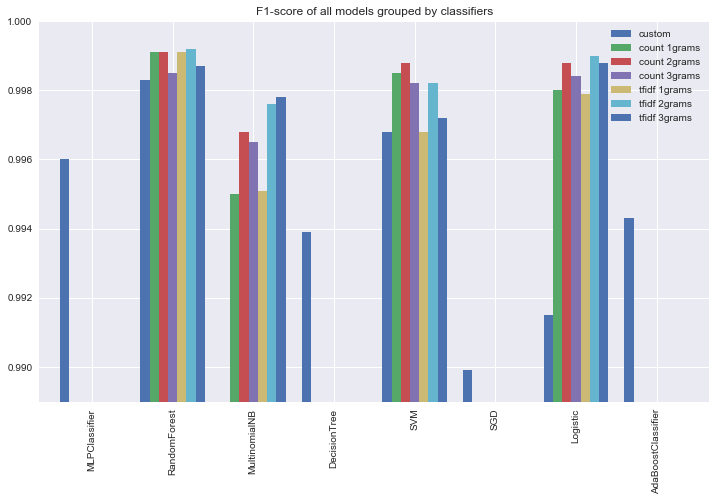

In [151]:
def get_classifier_name(index):
    '''
    Returns the name of the classifier at the given index name
    '''
    return index.split()[len(index.split())-1]
    
#Group rows together using same classifier
grouped = classifier_results.groupby(get_classifier_name)

hist_df = pd.DataFrame(columns=['custom','count 1grams','count 2grams','count 3grams','tfidf 1grams','tfidf 2grams','tfidf 3grams'])

for classifier, indices in grouped.groups.items():
    
    #Make a list of feature spaces
    feature_spaces = indices.tolist()
    feature_spaces = [feature_space.replace(classifier,'') for feature_space in feature_spaces]
    feature_spaces = [feature_space.strip() for feature_space in feature_spaces]

    #If no result exists, it will stay as 0
    hist_df.loc[classifier] = {
            'custom':0,
            'count 1grams':0,
            'count 2grams':0,
            'count 3grams':0,
            'tfidf 1grams':0,
            'tfidf 2grams':0,
            'tfidf 3grams':0
    }
    
    #Extract F1-score from classifier_results to corrensponding entry in hist_df
    for fs in feature_spaces:
        hist_df[fs].loc[classifier] = classifier_results['F1-score'].loc[fs + ' ' + classifier]
        

#Plot the bar plot
f, ax = plt.subplots()
ax.set_ylim([0.989,1])
hist_df.plot(kind='bar', figsize=(12,7), title='F1-score of all models grouped by classifiers', ax=ax, width=0.8)


#Make Avgerage F1-score row and cols for the table and print the table
hist_df_nonzero = hist_df.copy()
hist_df_nonzero[hist_df > 0] = True
hist_df['Avg Feature'] = (hist_df.sum(axis=1) / np.array(hist_df_nonzero.sum(axis=1)))
hist_df_nonzero = hist_df.copy()
hist_df_nonzero[hist_df > 0] = True
hist_df.loc['Avg Classifier'] = (hist_df.sum(axis=0) / np.array(hist_df_nonzero.sum(axis=0)))
hist_df = hist_df.round(4)
display(hist_df)


### Learning curves
Create learning curves for a sample of classifiers. This is to visualize how the dataset size impacts the performance

In [44]:
def plot_learning_curve(df_row,X,Y):
    '''Plots the learning curve of a classifier with its parameters
    
    input - df_row: row of classifier_result
            X: payload data
            Y: labels
    '''
    #The classifier to plot learning curve for
    estimator = df_row['model']
    
    title = 'Learning curves for classifier ' + df_row.name
    train_sizes = np.linspace(0.1,1.0,5)
    cv = ShuffleSplit(n=len(X), n_iter=3, test_size=0.2, random_state=0)
    
    #plot settings
    plt.figure()
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    
    print('learning curve in process...')
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, Y, cv=cv, n_jobs=-1, train_sizes=train_sizes, verbose=0) #Change verbose=10 to print progress
    print('Learning curve done!')
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    plt.show()

Three examples of learning curves from the trained classifiers.  
All learning curves have upsloping cross-validation score at the end,  
which means that adding more data would potentially increase the accuracy

learning curve in process...
Learning curve done!


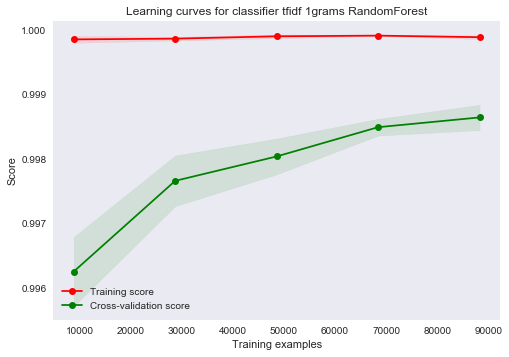

learning curve in process...
Learning curve done!


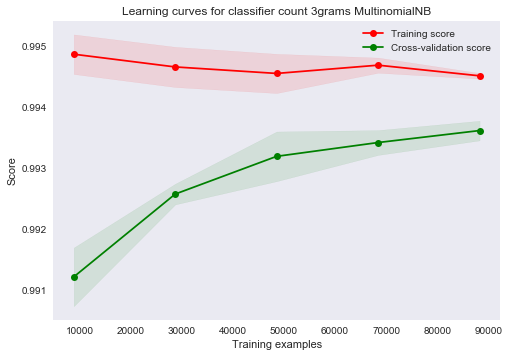

learning curve in process...
Learning curve done!


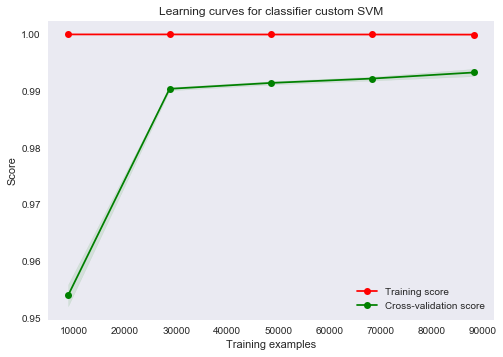

In [45]:
#plot learning curve for tfidf 1grams RandomForest
X = payloads['payload']
Y = payloads['is_malicious']
plot_learning_curve(classifier_results.iloc[0],X,Y)

#plot learning curve for count 3grams MultinomialNB
X = payloads['payload']
Y = payloads['is_malicious']
plot_learning_curve(classifier_results.iloc[6],X,Y)

#plot learning curve for custom svm
X = create_features(pd.DataFrame(payloads['payload'].copy()))
Y = payloads['is_malicious']
plot_learning_curve(classifier_results.iloc[5],X,Y)


### ROC curves
Plot ROC curves for a range of classifiers to visualize the sensitivity/specificity trade-off and the AUC

In [240]:
def visualize_result(classifier_list):
    '''Plot the ROC curve for a list of classifiers in the same graph
    
    input - classifier_list: a subset of classifier_results
    '''

    f, (ax1, ax2) = plt.subplots(1,2)
    f.set_figheight(6)
    f.set_figwidth(15)
    
    #Subplot 1, ROC curve
    for classifier in classifier_list:
        ax1.plot(classifier['roc']['fpr'], classifier['roc']['tpr'])
        ax1.scatter(1-classifier['specificity'],classifier['sensitivity'], edgecolor='k')
    ax1.set_xlim([0, 1])
    ax1.set_ylim([0, 1.0])
    ax1.set_title('ROC curve for top3 and bottom3 classifiers')
    ax1.set_xlabel('False Positive Rate (1 - Specificity)')
    ax1.set_ylabel('True Positive Rate (Sensitivity)')
    ax1.grid(True)
    
    #subplot 2, ROC curve zoomed
    for classifier in classifier_list:
        ax2.plot(classifier['roc']['fpr'], classifier['roc']['tpr'])
        ax2.scatter(1-classifier['specificity'],classifier['sensitivity'], edgecolor='k')
    ax2.set_xlim([0, 0.3])
    ax2.set_ylim([0.85, 1.0])
    ax2.set_title('ROC curve for top3 and bottom3 classifiers (Zoomed)')
    ax2.set_xlabel('False Positive Rate (1 - Specificity)')
    ax2.set_ylabel('True Positive Rate (Sensitivity)')
    ax2.grid(True)
    
    #Add further zoom
    left, bottom, width, height = [0.7, 0.27, 0.15, 0.15]
    ax3 = f.add_axes([left, bottom, width, height])
    
    for classifier in classifier_list:
        ax3.plot(classifier['roc']['fpr'], classifier['roc']['tpr'])
        ax3.scatter(1-classifier['specificity'],classifier['sensitivity'], edgecolor='k')
        
    ax3.set_xlim([0, 0.002])
    ax3.set_ylim([0.983, 1.0])
    ax3.set_title('Zoomed even further')
    ax3.grid(True)
    plt.show()
    

Plot ROC curves for the top3 classifiers and the bottom 3 classifiers, sorted by F1-score  
Left: standard scale ROC curve 
Right: zoomed in version of same graph, to easier see in the upper right corner

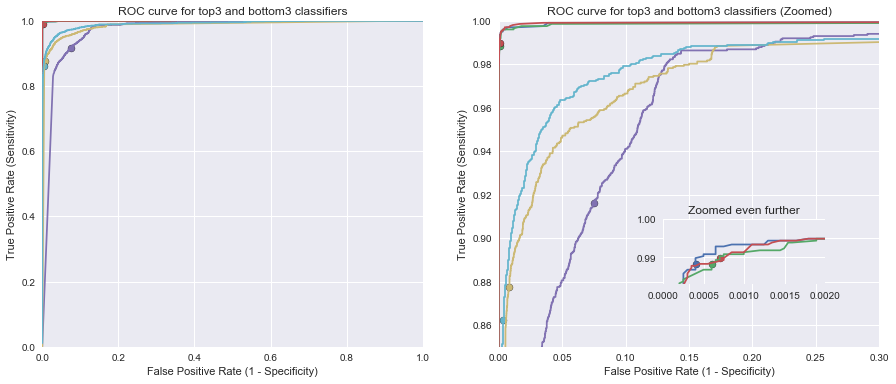

In [241]:
indices = [0,1,2, len(classifier_results)-1,len(classifier_results)-2,len(classifier_results)-3]
visualize_result([classifier_results.iloc[index] for index in indices])

## Step6 - Website integration extract
This is the code needed when implementing the saved classifier in tfidf_2grams_randomforest.p on a server

In [16]:
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier

def get2Grams(payload_obj):
    '''Divides a string into 2-grams
    
    Example: input - payload: "<script>"
             output- ["<s","sc","cr","ri","ip","pt","t>"]
    '''
    payload = str(payload_obj)
    ngrams = []
    for i in range(0,len(payload)-2):
        ngrams.append(payload[i:i+2])
    return ngrams

classifier = pickle.load( open("data/tfidf_2grams_randomforest.p", "rb"))

def injection_test(inputs):
    variables = inputs.split('&')
    values = [ variable.split('=')[1] for variable in variables]
    print(values)
    return 'MALICIOUS' if classifier.predict(values).sum() > 0 else 'NOT_MALICIOUS'


In [24]:
#test injection_test
display(injection_test("val1=%3Cscript%3Ekiddie"))

['%3Cscript%3Ekiddie']


'MALICIOUS'

# (Step7)
we can display which types of queries the classifiers failed to classify. These are interesting to examine for further work on how to improve the classifiers and the quality of the data set

In [38]:
pipe = Pipeline([('vect', vectorizer), ('clf',LogisticRegression(C=10))])
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

cv = ShuffleSplit(n=len(X_train), n_iter=1, test_size=0.2, random_state=0) #DEBUG: n_iter=10

random_grid_search = RandomizedSearchCV(
    pipe, 
    param_distributions={
        'clf__C':[10]
    },
    cv=cv, 
    scoring='roc_auc', 
    n_iter=1, 
    random_state=5,
    refit=True
)
random_grid_search.fit(X_train, Y_train)

#Evaluate the best model on the test data
Y_test_predicted = random_grid_search.best_estimator_.predict(X_test)


index
28660    dojo.io.script.jsonp_dojoIoScript60693._jsonpC...
17914                                      127.0.0.1 | id|
Name: payload, dtype: object

In [45]:
#Payloads classified incorrectly
pd.options.display.max_colwidth = 200
print('False positives')
print(X_test[(Y_test == 0) & (Y_test_predicted == 1)])
print('False negatives')
print(X_test[(Y_test == 1) & (Y_test_predicted == 0)])

False positives
index
28660    dojo.io.script.jsonp_dojoIoScript60693._jsonpCallback
17914                                          127.0.0.1 | id|
Name: payload, dtype: object
False negatives
index
8224                                                                                                                                                    '<'s'v'g' o'n'l'o'a'd'='a'l'e'r't'('7')' '>'
250                                                                                                                                                                b'<? popen($_REQUEST["c4"]); ?> '
9145                                                                                                                                                                       > XSS | Replacive Fuzzers
10000                                                                                                                                                                                           ;id;
9817         